In [ ]:
# 인용 : https://www.kaggle.com/asindico/customer-segments-with-pca
# 참조 : https://www.kaggle.com/mgabrielkerr/visualizing-knn-svm-and-xgboost-on-iris-dataset

+ **목적** : 구매이력 기반, 유의미한 그룹 분류
+ **방법** : ICA를 통한 차원축소 (6차원) 후, k-means (3-group)
+ **대상** : 19.09 구매회원 기준  
---  
+ **결론**
  + 그룹분류
    + 전체 : 라떼 선호 / 룽고 선호 /  S 사이즈 선호 
    + 임직원 : 아침식사 / 음료&제빵 / 주스류 구매
  + 기타 : 차원 선택 문제는 발생하지 않음

In [17]:
#######
# import
###

import cx_Oracle as oci
import pandas as pd

from sklearn.decomposition import FastICA    #ICA 모듈

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib as mpl
%matplotlib inline
import seaborn as sns
# sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [3]:
#######
#1. 자료추출(Oracel SQL)
###

## DB 접속
conn = oci.connect('*******************************************')

## query 실행( =자료 추출)
df_all = pd.read_sql("select S.stor_cd || S.pos_no || S.bill_no as order_no, S.Item_cd, S.sale_qty " + 
                     ", S.CUST_id "
                     "from sale_dt S, item I, c_cust C " +
                     "where S.sale_dt between '20190901' and '20190930' " +
                     "and S.item_cd = I.item_cd(+) " +
                     "and cust_stat <> 9 " +
                     "and C.cust_id = S.cust_id " +
                     "and S.t_seq = 0 " +
                     "and S.CUST_id is not null "
                      , con = conn )

## DB 접속종료
conn.close()

In [4]:
### 자료확인
df_all.head(3)

,ORDER_NO,ITEM_CD,SALE_QTY,CUST_ID
0,20000880100003,179549,1,!junie77
1,20000880100011,271028,1,!junie77
2,20000880100011,170157,1,!junie77


In [5]:
## pivot
cust_prod = pd.crosstab(df_all['CUST_ID'], df_all['ITEM_CD'])
cust_prod.head(5)

ITEM_CD,170039,170040,170048,170050,170052,170054,170055,170056,170058,170059,...,271036,271037,320005,320008,320022,320081,320084,320111,320117,320119
CUST_ID,,,,,,,,,,,,,,,,,,,,,
!junie77,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
!kby3831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#chrismh92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
.??.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0008051,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# ICA(독립성분분석)
ica = FastICA(n_components=6)
ica.fit(cust_prod)
ica_samples = ica.transform(cust_prod)

# ICA(독립성분분석) : DataFrame
ps = pd.DataFrame(ica_samples)

In [9]:
ps.head(5)

,0,1,2,3,4,5
0,0.001326,-0.004322,-0.000652,-0.001706,0.001752,-0.002733
1,0.000700,0.001222,-0.003260,-0.000973,-0.000139,0.001799
2,0.001397,0.001819,-0.000594,-0.001621,0.001645,-0.002964
3,0.001387,0.001217,-0.001196,-0.001231,0.000938,0.001534
4,0.001169,0.001439,-0.000403,-0.001248,0.001294,0.001586


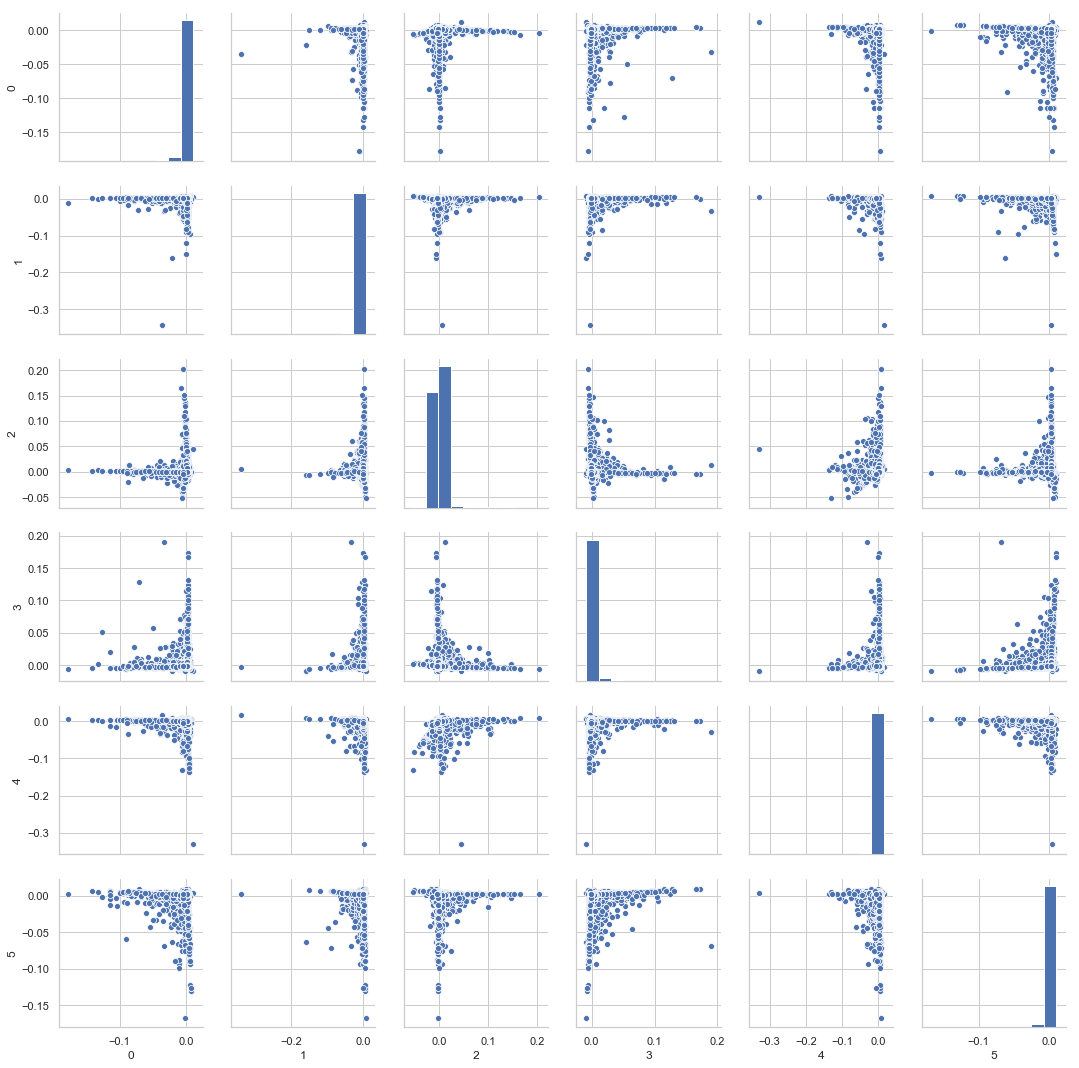

In [10]:
sns.pairplot(ps)
plt.show()

['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'green', 'orange', 'orange']


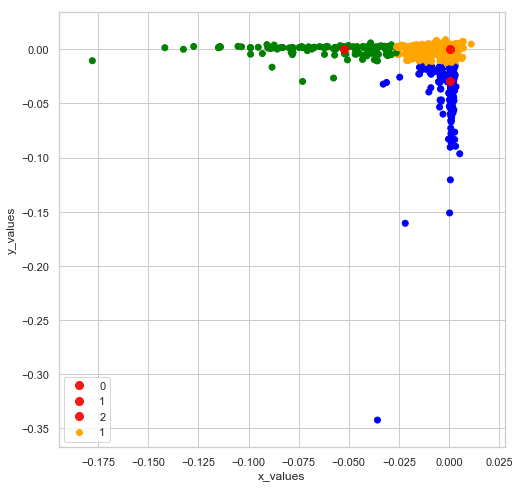

In [19]:
tocluster = pd.DataFrame(ps[[0,1]])

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[0],tocluster[1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [20]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()


In [21]:
pd.DataFrame(c0.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,0.384486
170080,0.225795
179437,0.207100
170134,0.161927
170155,0.158071
179438,0.151047
170039,0.139822
179549,0.136827
170054,0.133556


In [22]:
pd.DataFrame(c1.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
179549,4.793677
179548,1.276206
170157,0.928453
170134,0.557404
179437,0.410982
170080,0.364393
170039,0.252912
170132,0.241265
179438,0.186356


In [23]:
pd.DataFrame(c2.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170155,10.110092
170157,0.926606
170078,0.715596
170132,0.600917
179438,0.486239
170080,0.481651
170052,0.302752
179701,0.275229
270591,0.256881


In [24]:
# print (c_preds[0:100])

['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'green', 'orange', 'orange']


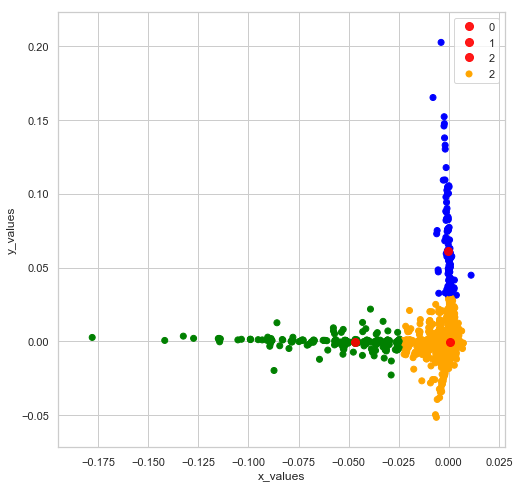

In [82]:
tocluster = pd.DataFrame(ps[[0,2]])

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[0],tocluster[2],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [26]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()

In [28]:
pd.DataFrame(c0.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,0.394192
179549,0.228906
170080,0.226664
179437,0.211311
170134,0.161583
179438,0.151461
170155,0.149389
170039,0.140455
170132,0.124762


In [29]:
pd.DataFrame(c1.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170054,8.837838
170134,1.824324
170052,0.702703
170039,0.418919
170080,0.412162
170157,0.398649
179548,0.351351
170065,0.351351
270888,0.344595


In [30]:
pd.DataFrame(c2.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170155,9.069091
170157,0.956364
170078,0.603636
170132,0.567273
170080,0.538182
179438,0.480000
179549,0.425455
179701,0.243636
170052,0.240000


['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'blue', 'orange', 'orange']


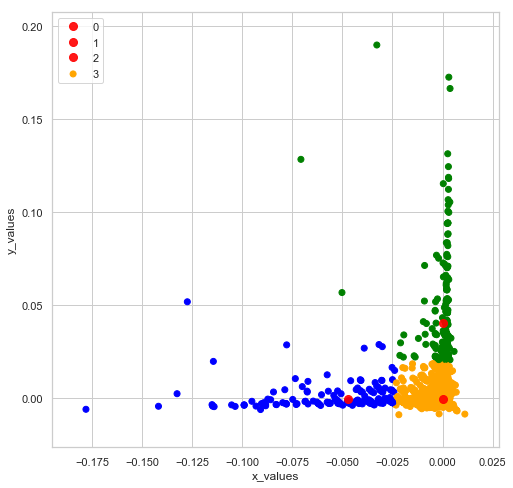

In [31]:
tocluster = pd.DataFrame(ps[[0,3]])

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[0],tocluster[3],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [32]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()

In [34]:
pd.DataFrame(c0.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,0.387438
179549,0.228677
179437,0.210873
170134,0.169867
170080,0.154319
179438,0.151483
170155,0.148544
170039,0.140685
170054,0.132039


In [35]:
pd.DataFrame(c1.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170155,9.055147
170157,0.893382
170078,0.591912
170132,0.555147
179438,0.448529
179549,0.411765
170080,0.316176
179701,0.246324
170052,0.242647


In [36]:
pd.DataFrame(c2.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170080,6.972477
170157,1.058104
170078,0.480122
179548,0.474006
170054,0.324159
179549,0.296636
170155,0.269113
170039,0.269113
179437,0.259939


['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'blue', 'orange', 'orange']


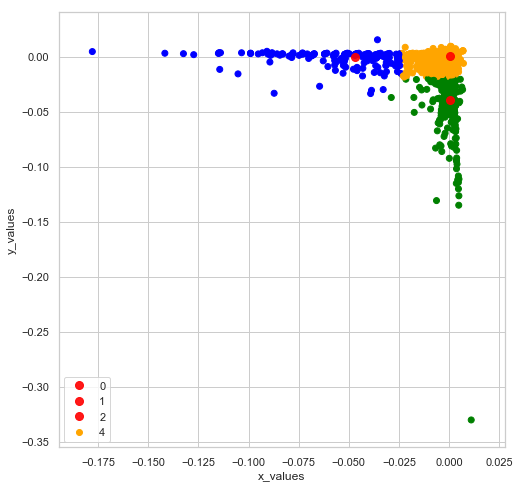

In [38]:
tocluster = pd.DataFrame(ps[[0,4]])

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[0],tocluster[4],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [40]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()

In [47]:
pd.DataFrame(c0.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,0.386340
170080,0.226294
179549,0.224756
179437,0.209202
179438,0.151603
170155,0.148732
170039,0.139297
179548,0.125590
170054,0.124154


In [42]:
pd.DataFrame(c1.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170155,9.083942
170157,0.959854
170078,0.605839
170080,0.540146
170132,0.525547
179438,0.481752
179549,0.427007
179701,0.244526
170052,0.240876


In [43]:
pd.DataFrame(c2.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170134,5.271642
170132,3.161194
170157,1.080597
170054,0.991045
179549,0.623881
170039,0.364179
179437,0.355224
170080,0.340299
179700,0.253731


['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'green', 'orange', 'orange']


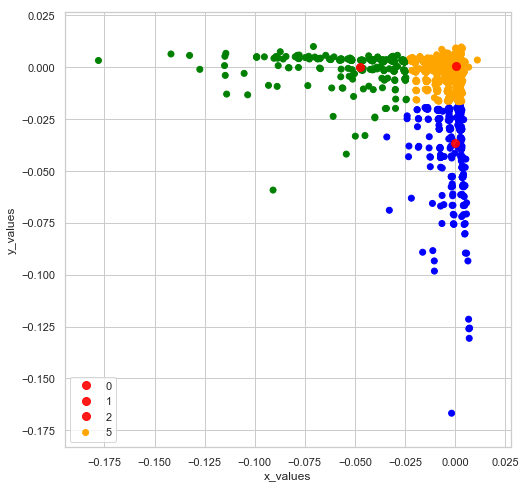

In [48]:
tocluster = pd.DataFrame(ps[[0,5]])

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[0],tocluster[5],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [49]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()

In [50]:
pd.DataFrame(c0.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,0.280308
179549,0.222588
170080,0.220805
179437,0.208398
170134,0.165073
179438,0.151431
170155,0.142999
170039,0.141011
170054,0.134087


In [51]:
pd.DataFrame(c1.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,8.450839
170080,0.779376
179549,0.705036
170155,0.613909
170134,0.513189
179437,0.422062
170039,0.215827
179700,0.206235
271028,0.184652


In [52]:
pd.DataFrame(c2.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170155,9.114391
170157,0.830258
170078,0.594096
170132,0.549815
179438,0.450185
170080,0.424354
179549,0.416974
179701,0.247232
170052,0.243542


['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


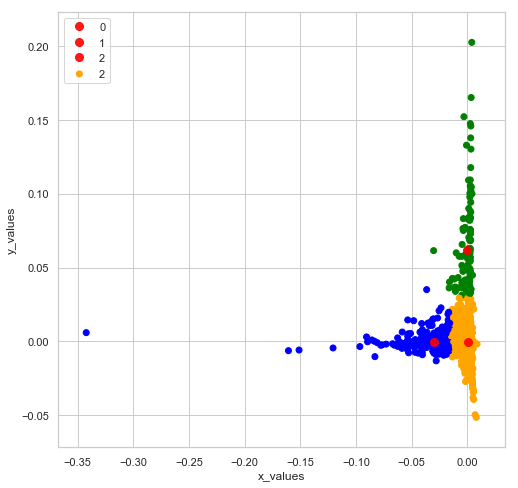

In [53]:
tocluster = pd.DataFrame(ps[[1,2]])

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','green','purple']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[1],tocluster[2],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [54]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()

In [55]:
pd.DataFrame(c0.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,0.388460
170155,0.231736
170080,0.226756
179437,0.206595
179438,0.153873
170134,0.153804
170039,0.138348
179549,0.136837
170132,0.126464


In [56]:
pd.DataFrame(c1.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
179549,4.788686
179548,1.304493
170157,0.930116
170134,0.534110
179437,0.410982
170080,0.366057
170039,0.252912
170132,0.244592
170155,0.241265


In [57]:
pd.DataFrame(c2.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170054,8.863946
170134,1.809524
170052,0.707483
170039,0.421769
170080,0.408163
170157,0.394558
170065,0.353741
270888,0.346939
179548,0.346939


['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


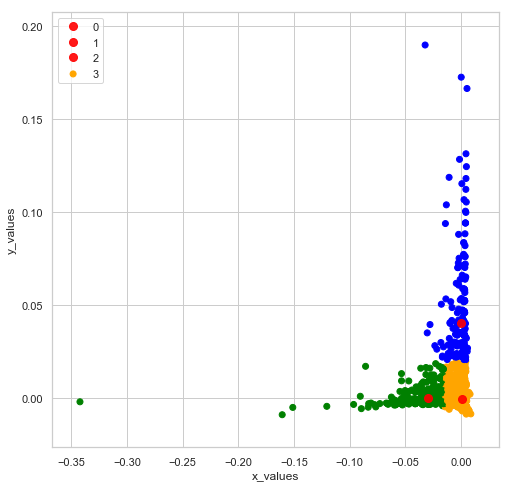

In [62]:
tocluster = pd.DataFrame(ps[[1,3]])

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[1],tocluster[3],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [63]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()

In [64]:
pd.DataFrame(c0.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,0.381415
170155,0.228635
179437,0.206379
170134,0.161765
179438,0.153679
170080,0.153160
170039,0.138750
179549,0.136331
170054,0.131147


In [65]:
pd.DataFrame(c1.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170080,6.948795
170157,1.057229
170078,0.539157
179548,0.475904
170155,0.433735
170054,0.328313
179549,0.292169
170039,0.268072
179437,0.256024


In [66]:
pd.DataFrame(c2.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
179549,4.813131
179548,1.264310
170157,0.907407
170134,0.550505
179437,0.375421
170080,0.240741
170132,0.240741
170039,0.232323
170155,0.232323


['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


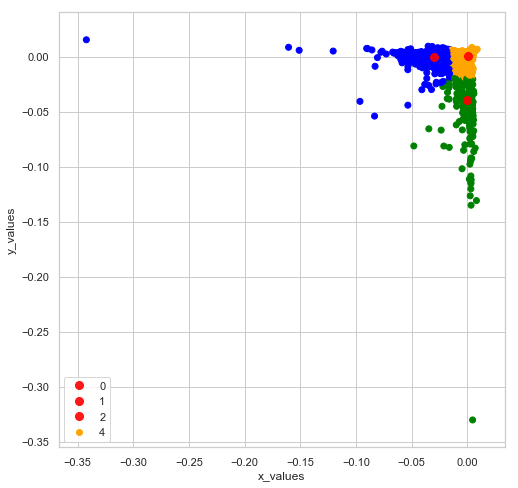

In [76]:
tocluster = pd.DataFrame(ps[[1,4]])

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[1],tocluster[4],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [78]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()

In [79]:
pd.DataFrame(c0.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,0.381193
170155,0.229945
170080,0.226525
179437,0.205141
179438,0.153838
170039,0.137359
179549,0.136081
170054,0.123851
170134,0.107683


In [80]:
pd.DataFrame(c1.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
179549,4.809847
179548,1.319185
170157,0.923599
179437,0.407470
170134,0.390492
170080,0.356537
170155,0.244482
170039,0.244482
170132,0.212224


In [81]:
pd.DataFrame(c2.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170134,5.237805
170132,3.274390
170157,1.064024
170054,0.996951
179549,0.393293
170039,0.371951
170080,0.350610
179437,0.310976
170155,0.298780


['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


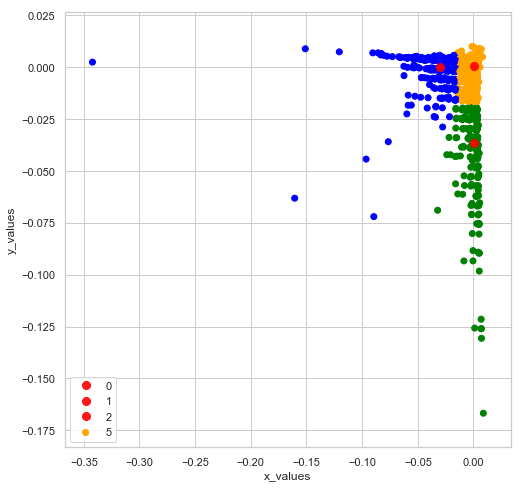

In [74]:
tocluster = pd.DataFrame(ps[[1,5]])

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[1],tocluster[5],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [68]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()

In [69]:
pd.DataFrame(c0.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,0.277468
170155,0.222480
170080,0.220886
179437,0.204012
170134,0.156682
179438,0.153945
170039,0.138942
179549,0.135338
170054,0.133121


In [75]:
pd.DataFrame(c1.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
179549,4.820339
179548,1.311864
170157,0.738983
170134,0.564407
179437,0.379661
170080,0.311864
170039,0.244068
170132,0.242373
170155,0.223729


In [71]:
pd.DataFrame(c2.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,8.453883
170155,0.837379
170080,0.783981
170134,0.509709
179437,0.407767
179549,0.366505
170039,0.213592
179700,0.203883
271028,0.182039
